In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy as sp
import os

def science_plot(fontsize = 8):
    import scienceplots
    plt.style.use(['science','grid','notebook'])
    plt.rcParams.update({
        'font.size'       : fontsize,    # General font size
        'axes.titlesize'  : fontsize,    # Font size of the axes title
        'axes.labelsize'  : fontsize,    # Font size of the axes labels
        'xtick.labelsize' : fontsize,    # Font size of the x-axis tick labels
        'ytick.labelsize' : fontsize,    # Font size of the y-axis tick labels
        'legend.fontsize' : fontsize,    # Font size of the legend
        'figure.titlesize': fontsize,    # Font size of the figure title
        'legend.fancybox' : False,       # Disable the fancy box for legend
        'legend.edgecolor': 'k',         # Set legend border color to black
        'text.usetex'     : True,        # Use LaTeX for text rendering
        'font.family'     : 'serif'      # Set font family to serif
    })
science_plot()


def r_squared(x_exp, y_exp, slope_theo, intercept_theo):
    """
    Computes the R^2 value given experimental x and y values, 
    and a theoretical slope and intercept.
    
    Parameters:
    x_exp (array-like): Experimental x values
    y_exp (array-like): Experimental y values
    slope_theo (float): Theoretical slope
    intercept_theo (float): Theoretical intercept

    Returns:
    float: R^2 value
    """
    # Compute the predicted y values using the theoretical model
    y_theo = slope_theo * np.array(x_exp) + intercept_theo

    # Compute the total sum of squares (TSS)
    y_mean = np.mean(y_exp)
    ss_total = np.sum((y_exp - y_mean) ** 2)

    # Compute the residual sum of squares (RSS)
    ss_residual = np.sum((y_exp - y_theo) ** 2)

    # Compute R^2
    r2 = 1 - (ss_residual / ss_total)
    return r2

def p_value_from_r2(r2, n, k=1):
    """
    Computes the p-value from the R^2 value for a linear regression model.

    Parameters:
    r2 (float): R^2 value
    n (int): Number of data points
    k (int): Number of predictors (default is 1 for simple linear regression)

    Returns:
    float: p-value for the regression model
    """
    if r2 >= 1:
        return 0.0  # Perfect fit, p-value is essentially 0
    
    if r2 <= 0:
        return 1.0  # No fit, p-value is 1
    
    # Compute the F-statistic
    F_stat = (r2 / k) / ((1 - r2) / (n - k - 1))

    # Compute the p-value (1 - CDF of F-distribution)
    p_value = 1 - f.cdf(F_stat, dfn=k, dfd=(n - k - 1))
    return p_value

def best_fit_line(x_exp, y_exp, dx=0.1):
    """
    Computes the best-fit line (linear regression) for a given set of experimental data points.

    Parameters:
    x_exp (array-like): Experimental x values.
    y_exp (array-like): Experimental y values.
    dx (float, optional): Step size for generating x-values for the fitted line (default is 0.1).

    Returns:
    tuple: (x_vals, y_vals, slope, intercept)
        - x_vals (numpy.ndarray): X values used for plotting the best-fit line.
        - y_vals (numpy.ndarray): Corresponding Y values of the best-fit line.
        - slope (float): Best-fit slope.
        - intercept (float): Best-fit intercept.
    """
    # Convert inputs to numpy arrays to ensure proper calculations
    x_exp = np.asarray(x_exp, dtype=float)
    y_exp = np.asarray(y_exp, dtype=float)
    
    # Compute the best-fit slope and intercept using linear regression
    slope, intercept = np.polyfit(x_exp, y_exp, 1)

    # Generate x values for plotting the best-fit line
    x_vals = np.linspace(np.min(x_exp), np.max(x_exp), num=int((np.max(x_exp) - np.min(x_exp)) / dx) + 1)
    
    # Compute corresponding y values for the best-fit line
    y_vals = slope * x_vals + intercept

    return x_vals, y_vals, slope, intercept

def calculate_LE_average(scores):
    """
    Given a list of four scores, this function drops the lowest or any NaN value,
    and returns the average of the remaining three. If more than one value is NaN,
    the function returns NaN.

    Parameters:
    scores (list): A list of four numerical scores.

    Returns:
    float: The average of the top three scores, or NaN if more than one value is NaN.
    """
    # Ensure the input is a list with four elements
    if not isinstance(scores, list) or len(scores) != 4:
        raise ValueError("Input must be a list of four numerical scores.")

    # Count the number of NaN values
    nan_count = sum(np.isnan(score) for score in scores)

    # If more than one NaN, return NaN
    if nan_count > 1:
        return np.nan

    # Remove NaN values
    valid_scores = [score for score in scores if not np.isnan(score)]

    # If there's exactly one NaN, remove it and the lowest of the remaining three
    if nan_count == 1:
        valid_scores.remove(min(valid_scores))

    # If there are no NaNs, remove the lowest of the four scores
    else:
        valid_scores.remove(min(scores))

    # Calculate and return the average of the remaining three scores
    return np.mean(valid_scores)

In [2]:
grade_file = r"C:\Users\ADMIN\Documents\Code Stuff\Python\Physics 157 stuff\Physics 7x Statistics.xlsx"
df = pd.read_excel(grade_file,header=1, engine="openpyxl")
df = df.iloc[0:].reset_index(drop=True)
df.replace('NA', pd.NA, inplace=True)
df = df.iloc[1:].reset_index(drop=True)
print(df)

    STUDENT  YEAR  COURSE  SCHOOL YR SEMESTER LECTURE DAYS LECTURE HRS  \
0         1  2023   BS CS  2024-2025      1st          W,F   7:00-8:30   
1         2  2024  BS ChE  2024-2025      1st          W,F   7:00-8:30   
2         3  2023  BS Bio  2024-2025      1st          W,F   7:00-8:30   
3         4  2024  BS CoE  2024-2025      1st          W,F   7:00-8:30   
4         5  2024  BS CoE  2024-2025      1st          W,F   7:00-8:30   
..      ...   ...     ...        ...      ...          ...         ...   
421     423  2024   BS EM  2024-2025      1st          W,F   2:30-4:00   
422     424  2024   BS GE  2024-2025      1st          W,F   2:30-4:00   
423     425  2024   BS IE  2024-2025      1st          W,F   2:30-4:00   
424     426  2024   BS IE  2024-2025      1st          W,F   2:30-4:00   
425     427  2024   BS IE  2024-2025      1st          W,F   2:30-4:00   

    DISCUSSION DAY DISCUSSION HR PS 1 PS 2 PS 3 LE1 LE2 LE3  LE4 Final Grade  \
0                T     7:00-8:0

R^2 val is 0.044163124970296036
p value is 1.375425501260442e-05, statistically significant


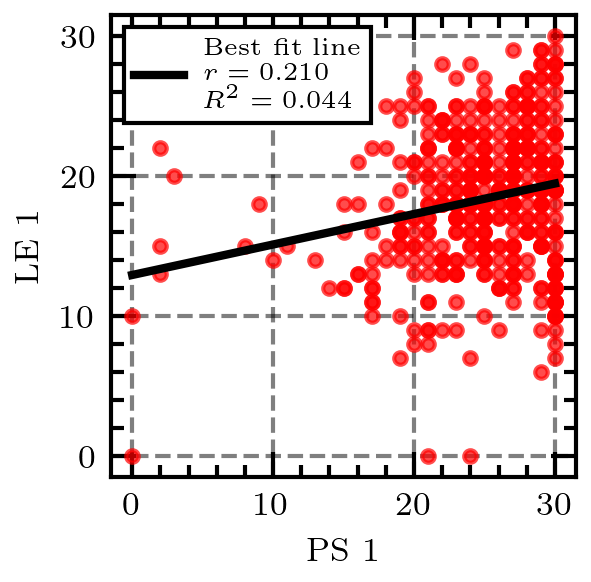

R^2 val is 0.08730436157529473
p value is 6.584037741425928e-10, statistically significant


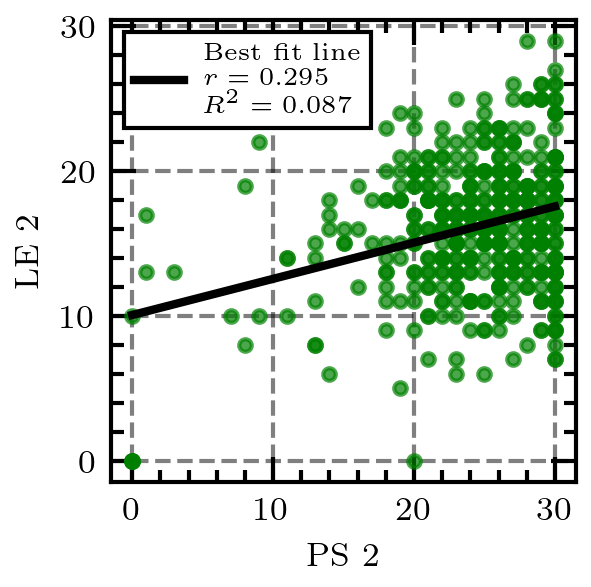

R^2 val is 0.05921475971138449
p value is 4.903487743023719e-07, statistically significant


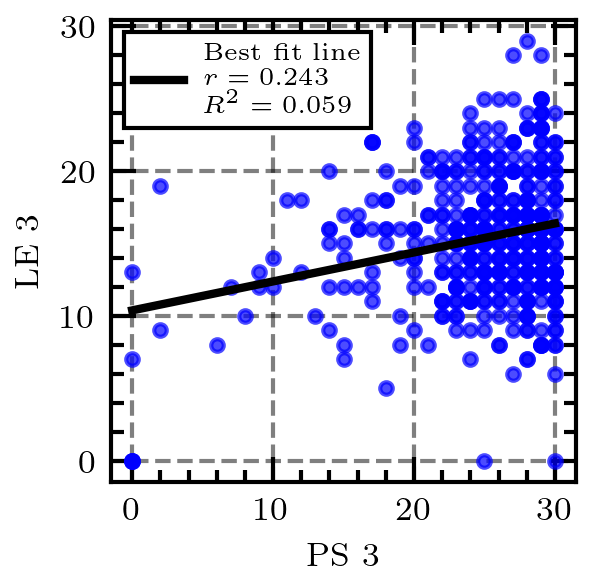

In [3]:
# A
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
savepath = r'C:\Users\ADMIN\Documents\Code Stuff\Python\Physics 157 stuff\images'

def best_fitter(x, y):
    x_exp = np.asarray(x, dtype=float)
    y_exp = np.asarray(y, dtype=float)
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(x_exp, y_exp)
    x_bf,y_bf, _, _ = best_fit_line(x_exp, y_exp)
    r2 = r_value**2
    print(f'R^2 val is {r2}')
    if p_value > 0.05:
        print(f'p value is {p_value}, not statistically significat')
    else:
        print(f'p value is {p_value}, statistically significant')
    return x_bf, y_bf, r2, r_value

df1 = df.dropna(subset = ['PS 1','LE1'])
x_exp, y_exp = df1['PS 1'], df1['LE1']
plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(x_exp, y_exp, color = 'r', alpha = 0.7, marker = '.')
x_bf, y_bf, r2, r = best_fitter(x_exp, y_exp)
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r  = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.xlabel('PS 1')
plt.ylabel('LE 1')
plt.legend(loc="upper left", prop={'size': 6})
fignum = 0
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

df2 = df.dropna(subset = ['PS 2','LE2'])

plt.figure(figsize = (2,2), dpi= 300)
x_bf, y_bf, r2 ,r = best_fitter(df2['PS 2'], df2['LE2'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r  = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.scatter(df2['PS 2'], df2['LE2'], color = 'g', alpha = 0.7, marker = '.')
plt.xlabel('PS 2')
plt.ylabel('LE 2')
plt.legend(loc="upper left", prop={'size': 6})
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

df3 = df.dropna(subset = ['PS 3','LE3'])
plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(df3['PS 3'], df3['LE3'], color = 'b', alpha = 0.7, marker = '.')
x_bf, y_bf, r2, r = best_fitter(df3['PS 3'], df3['LE3'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r  = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel('PS 3')
plt.ylabel('LE 3')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.11912649400173096
p value is 2.9574172501523385e-11, statistically significant


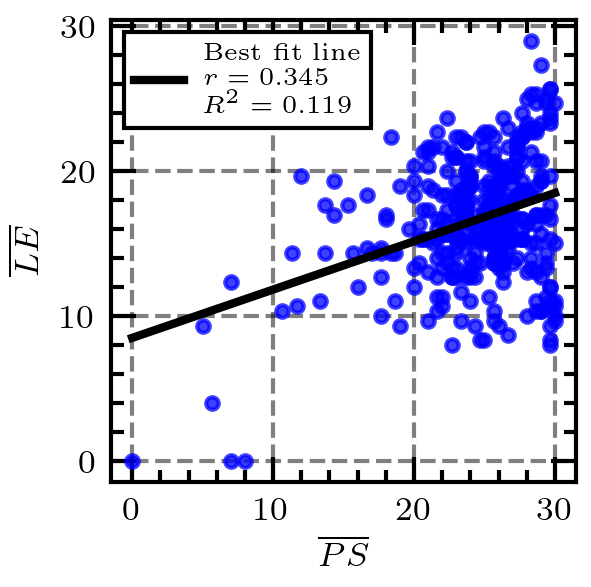

In [4]:
# Part B
dfB = df.copy()
dfB = dfB.dropna()
#dfB['LE ave'] = dfB.apply(lambda row: calculate_LE_average([row['LE1'], row['LE2'], row['LE3'], row['LE4']]), axis=1)
dfB['LE ave'] = dfB[['LE1' , 'LE2' , 'LE3' ]].mean(axis=1)
dfB['PS ave'] = dfB[['PS 1', 'PS 2', 'PS 3']].mean(axis=1)

plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(dfB['PS ave'], dfB['LE ave'], color = 'b', marker = '.', alpha = 0.75)#, edgecolor = 'k')
x_bf, y_bf, r2, r =best_fitter(dfB['PS ave'], dfB['LE ave'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r  = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'$\overline{PS}$')
plt.ylabel(r'$\overline{LE}$')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.10225089019038995
p value is 8.723047632894757e-10, statistically significant


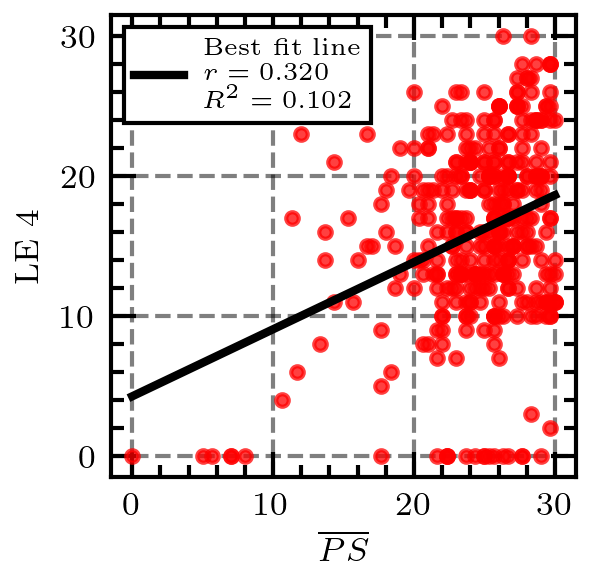

In [5]:
# C
dfC = df.copy()
dfC = dfC.dropna()
dfC['PS ave'] = dfC[['PS 1','PS 2','PS 3']].mean(axis=1)
dfC['LE final'] = dfC['LE4']
# print(dfC[['LE ave','LE final']])
plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(dfC['PS ave'], dfC['LE final'] , color = 'r', marker = '.', alpha=0.75)
x_bf, y_bf, r2, r =best_fitter(dfC['PS ave'], dfC['LE final'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'$\overline{PS}$')
plt.ylabel(r'LE 4')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.4155008577647482
p value is 1.3273744610925497e-42, statistically significant


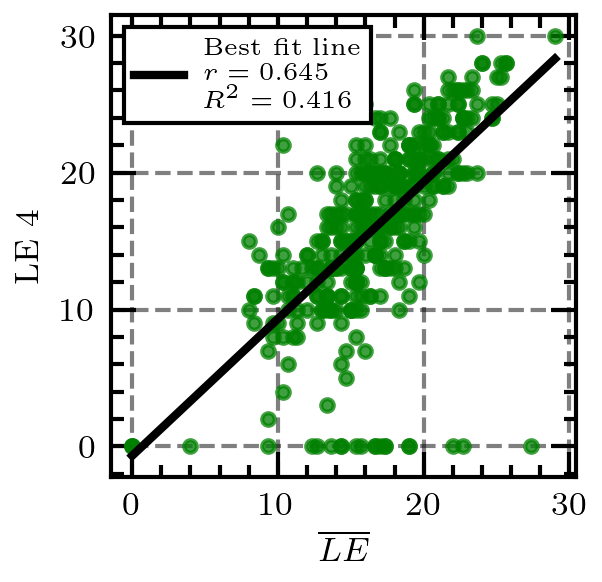

In [6]:
# D
dfD = df.copy()
dfD = dfD.dropna()
dfD['LE ave'] = dfD[['LE1','LE2','LE3']].mean(axis=1)
dfD['LE final'] = dfD['LE4']
# print(dfC[['LE ave','LE final']])
plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(dfD['LE ave'], dfD['LE final'] , color = 'g', marker = '.', alpha=0.75)
x_bf, y_bf, r2, r =best_fitter(dfD['LE ave'], dfD['LE final'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'$\overline{LE}$')
plt.ylabel(r'LE 4')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.9149050999679377
p value is 8.271411483785827e-189, statistically significant


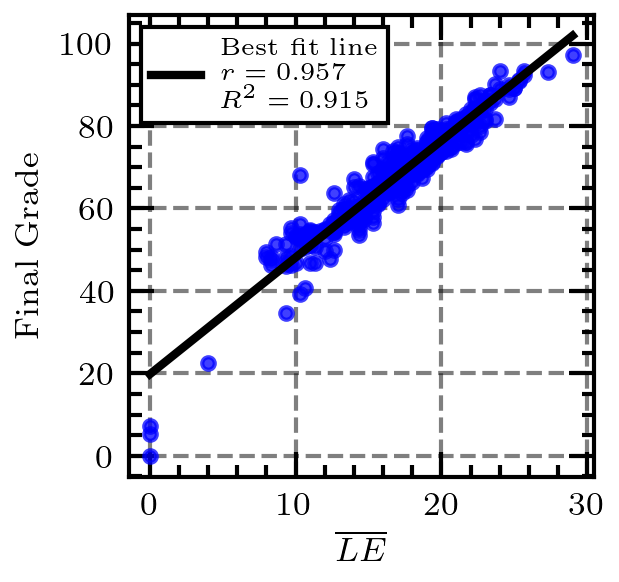

In [7]:
dfE = df.copy()
dfE = dfE.dropna()
dfE['LE ave'] = dfE[['LE1','LE2','LE3']].mean(axis=1)
x = np.array(dfE['LE ave'])
y = np.array(dfE['Final Grade'])
plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(x,y, color = 'b', marker = '.', alpha = 0.75)
x_bf, y_bf, r2, r =best_fitter(x, y)
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'$\overline{LE}$')
plt.ylabel(r'Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.246134624281737
p value is 3.3013126380155774e-23, statistically significant


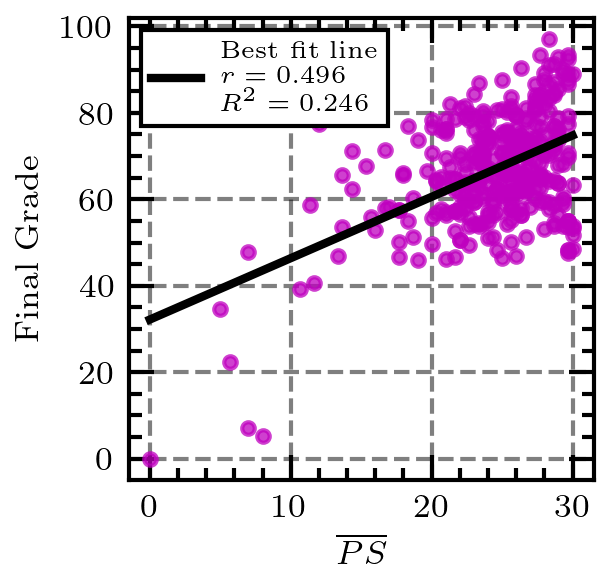

In [8]:
dfF = df.copy()
dfF = dfF.dropna()
dfF['PS ave'] = dfF[['PS 1','PS 2','PS 3']].mean(axis=1)

plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(dfF['PS ave'], dfF['Final Grade'] , color = 'm', marker = '.', alpha = 0.75)
x_bf, y_bf, r2, r =best_fitter(dfF['PS ave'], dfF['Final Grade'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'$\overline{PS}$')
plt.ylabel(r'Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

R^2 val is 0.5577273245755813
p value is 8.490895560581753e-64, statistically significant


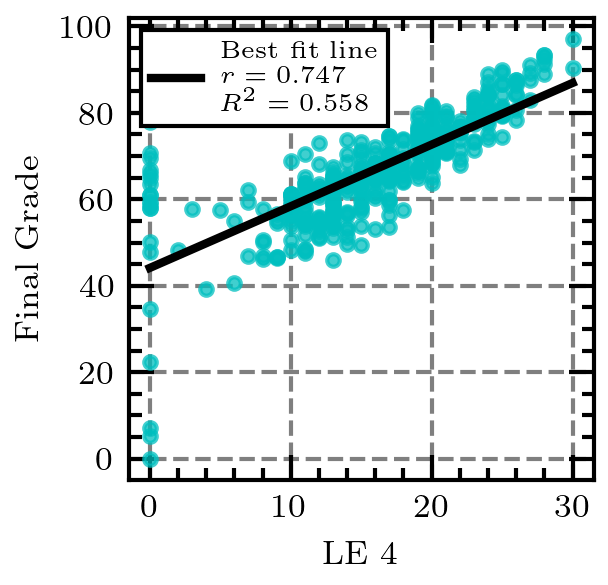

In [9]:
# G
dfG = df.copy()
dfG = dfG.dropna()

plt.figure(figsize = (2,2), dpi= 300)
plt.scatter(dfG['LE4'], dfG['Final Grade'], marker = '.', color = 'c', alpha = 0.75)
x_bf, y_bf, r2, r =best_fitter(dfG['LE4'], dfG['Final Grade'])
plt.plot(x_bf,y_bf, color = 'k', label = f'Best fit line \n $r = {r:.3f}$ \n $R^2 = {r2:.3f}$')
plt.legend(loc="upper left", prop={'size': 6})
plt.xlabel(r'LE 4')
plt.ylabel(r'Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

In [10]:
# ----------------- Specials -----------------  #
# Class Schedule v. Final Grades /\\
# Discussion Quiz Day v. Final Grade /\\
# Degree Program /\\

# Final grade v college /\\
# Final Grade v semester /\\
# Final Grade v lecture hours /\\
# Pop v Ave grade  
# performance of each course per long exam /\\

   LECTURE HRS Average Grade        STD
0    7:00-8:30     66.090161  15.224363
1   8:30-10:00     62.765067  12.715055
2  10:00-11:30     75.194888   9.756646
3  11:30-13:00       65.7775   9.345377
4  13:00-14:30     66.723182   7.237054
5  14:30-16:00     66.258315  12.689552


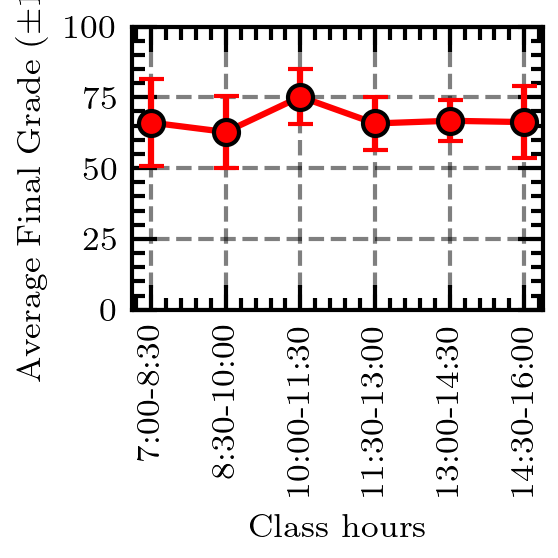

In [11]:
dfI = df.copy()
dfI["LECTURE HRS"] = dfI["LECTURE HRS"].replace("2:30-4:00", "14:30-16:00")
dfI["LECTURE HRS"] = dfI["LECTURE HRS"].replace("11:30-1:00", "11:30-13:00")

# Compute the mean and stddev per lecture hour
df_avg = dfI.groupby("LECTURE HRS")["Final Grade"].agg(['mean', 'std']).reset_index()

# Rename columns
df_avg.rename(columns={'mean': 'Average Grade', 'std': 'STD'}, inplace=True)

# Sort by start time
df_avg = df_avg.sort_values(by="LECTURE HRS", key=lambda x: x.str.split('-').str[0].str.split(':').str[0].astype(int))

# Reset index
df_avg.reset_index(drop=True, inplace=True)
print(df_avg)
# Plot
plt.figure(figsize=(2,2), dpi=300)
plt.errorbar(
    df_avg['LECTURE HRS'], 
    df_avg['Average Grade'], 
    yerr=df_avg['STD'], 
    fmt='o', capsize=3, 
    color='r', 
    markeredgecolor='k', 
    elinewidth = 1.5, 
    linestyle = '-',
    linewidth = 1.5)
plt.ylim(0, 100)
plt.xticks(rotation=90)
plt.xlabel('Class hours')
plt.ylabel(r'Average Final Grade ($\pm 1\sigma$)')
plt.tight_layout()

# Save figure
fignum += 1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

  DISCUSSION DAY Average Grade        STD
0              M             0        NaN
1              T     66.280471  14.064165
2              W     65.154289  15.168069
3             Th             0        NaN
4              F     65.544573  11.822673


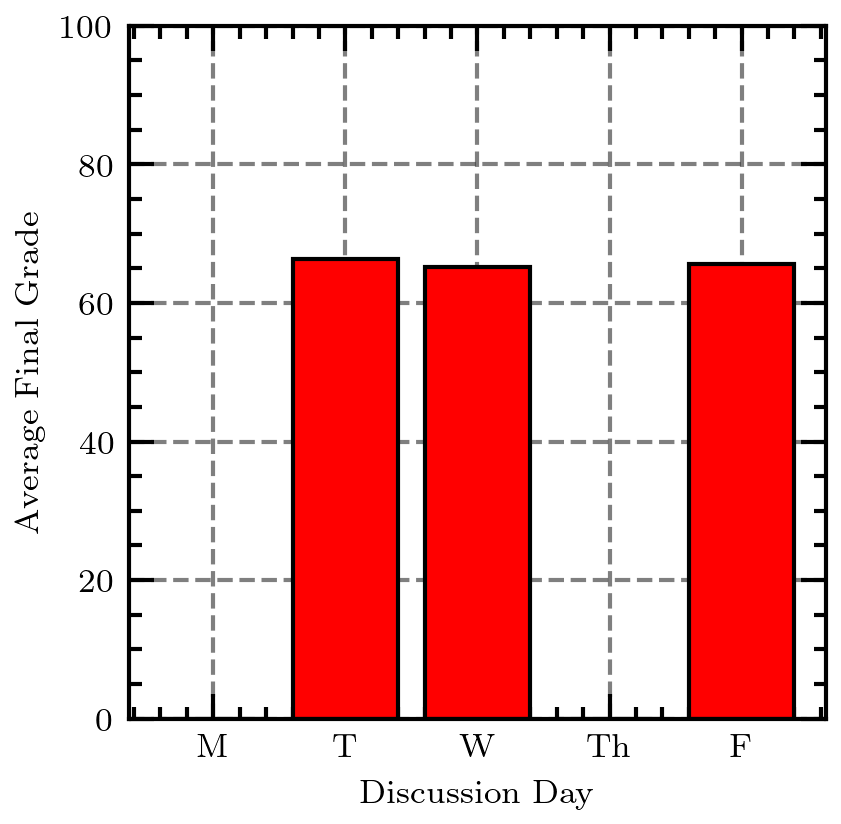

In [12]:
dfI = df.copy()
# dfI = dfI.dropna()

# Compute the average grade per class hour
df_dsc = dfI.groupby("DISCUSSION DAY")["Final Grade"].agg(['mean', 'std']).reset_index()
df_dsc.rename(columns={'mean': 'Average Grade', 'std': 'STD'}, inplace=True)

# Add missing days
missing_days = pd.DataFrame({
    "DISCUSSION DAY": ["M", "Th"],
    "Average Grade": [0, 0]  # Assuming 0 for missing grades
})
df_dsc = pd.concat([df_dsc, missing_days], ignore_index=True)

# Define the correct order
day_order = pd.CategoricalDtype(["M", "T", "W", "Th", "F"], ordered=True)

# Convert and sort
df_dsc["DISCUSSION DAY"] = df_dsc["DISCUSSION DAY"].astype(day_order)
df_dsc = df_dsc.sort_values(by="DISCUSSION DAY").reset_index(drop=True)

# Print result
print(df_dsc)

plt.figure(figsize = (3,3), dpi = 300)
plt.bar(df_dsc["DISCUSSION DAY"],df_dsc["Average Grade"], color = 'r', edgecolor = 'k')
plt.ylim(0,100)
plt.xlabel('Discussion Day')
plt.ylabel('Average Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

    index   COURSE Final Grade
0       3    BS CN        74.9
1      14   BS MBB   73.336889
2      15    BS ME   73.212037
3      12  BS Geol   71.570833
4       4    BS CS   69.300018
5       5   BS ChE    69.18261
6      17  BS Math   68.415671
7       9    BS EE   67.498792
8      13    BS IE   67.110134
9       7   BS CoE   65.763371
10      2    BS CE   65.180613
11      8   BS ECE   64.981272
12     11    BS GE   62.896667
13     18  BS MetE   62.262469
14      6  BS Chem   61.881852
15     16  BS MatE   58.795455
16      0  BS Arch   56.910419
17     10    BS EM   52.474815
18      1   BS Bio   50.769444
19     19  NON-MAJ       41.83


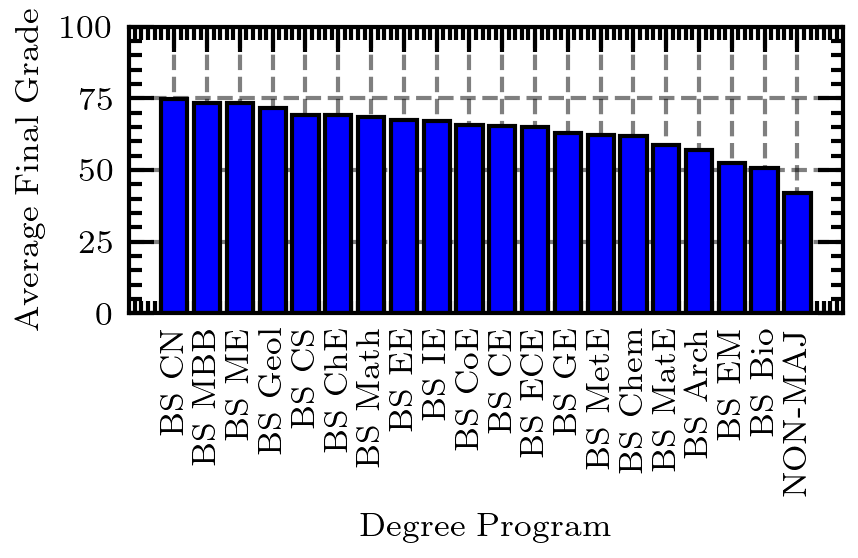

In [13]:
dfI = df.copy()
# dfI = dfI.dropna()

# Compute the average grade per course
df_deg = dfI.groupby("COURSE")["Final Grade"].mean().reset_index()
df_deg = df_deg.sort_values(by="Final Grade", ascending=False).reset_index()
print(df_deg)

plt.figure(figsize = (3,2), dpi = 300)
plt.bar(df_deg["COURSE"],df_deg["Final Grade"], color = 'b', edgecolor = 'k')
plt.ylim(0,100)
plt.xticks(rotation=90)
plt.xlabel('Degree Program')
plt.ylabel('Average Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.tight_layout()
plt.show()

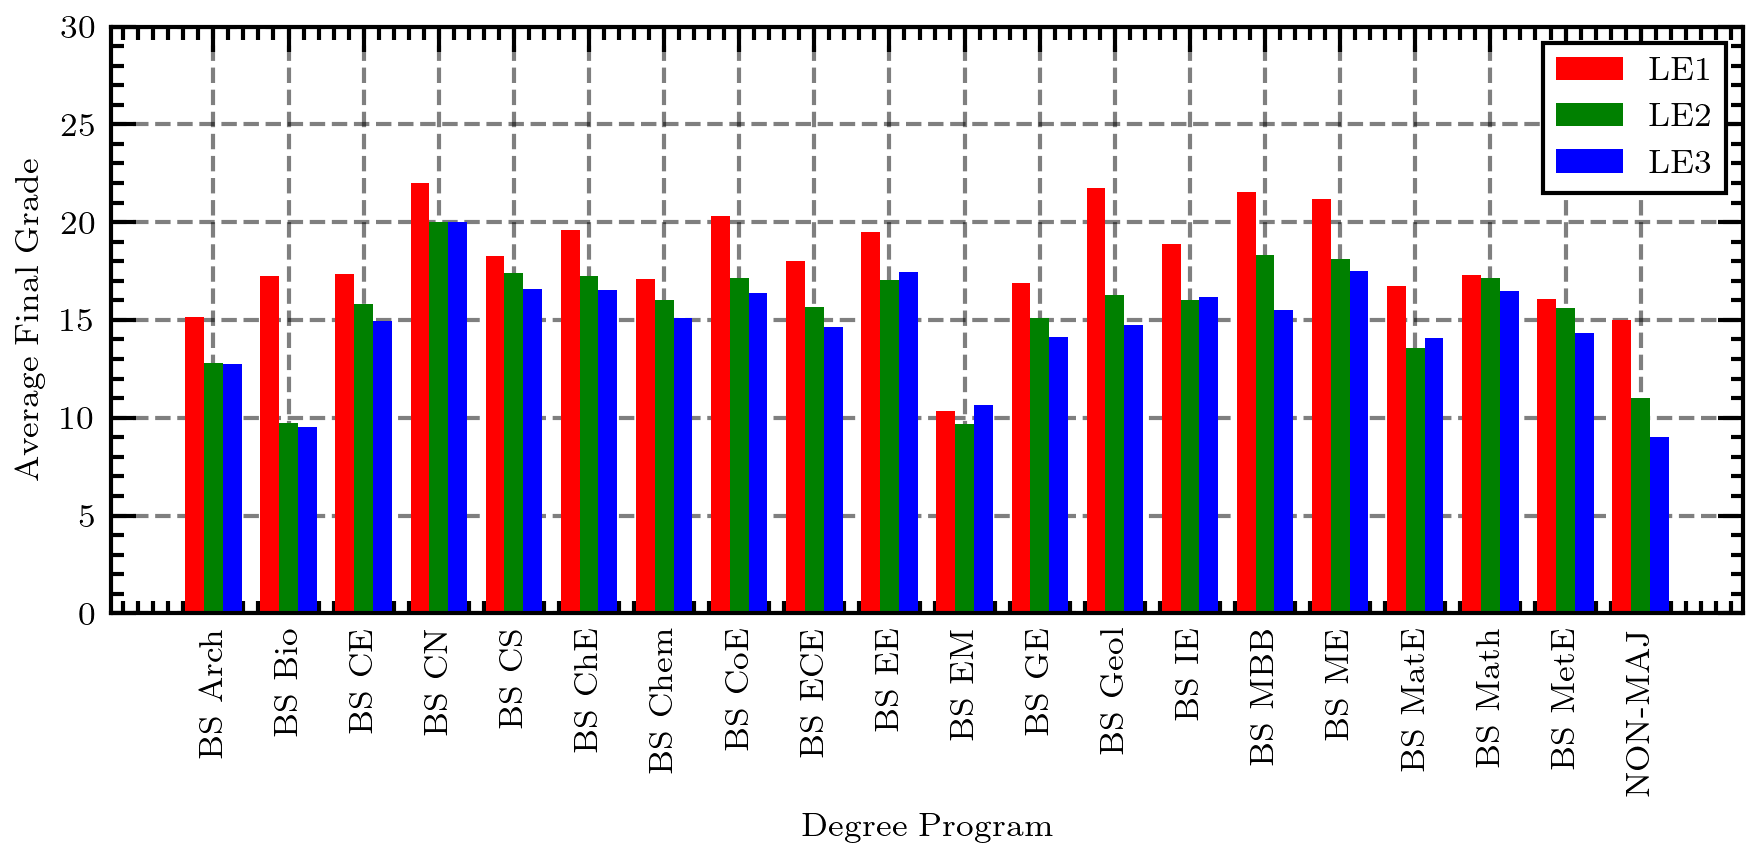

In [14]:
dfI = df.copy()

# Compute the average grade per course for each LE
df_avg = dfI.groupby("COURSE")[["LE1", "LE2", "LE3"]].mean().reset_index()

# Define positions for bars
x = np.arange(len(df_avg["COURSE"]))  # Numeric positions for each course
width = 0.25  # Width of each bar

plt.figure(figsize=(6, 3), dpi=300)

# Plot each LE with offsets
plt.bar(x - width, df_avg["LE1"], width=width, color='r', label='LE1')
plt.bar(x        , df_avg["LE2"], width=width, color='g', label='LE2')
plt.bar(x + width, df_avg["LE3"], width=width, color='b', label='LE3')

# Formatting
plt.ylim(0, 30)
plt.xticks(x, df_avg["COURSE"], rotation=90)
plt.xlabel('Degree Program')
plt.ylabel('Average Final Grade')
plt.legend()
plt.tight_layout()
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()


     LE      score       std
0  LE 1  18.255924  5.104225
1  LE 2  16.070922  4.686846
2  LE 3  15.249406  4.681476


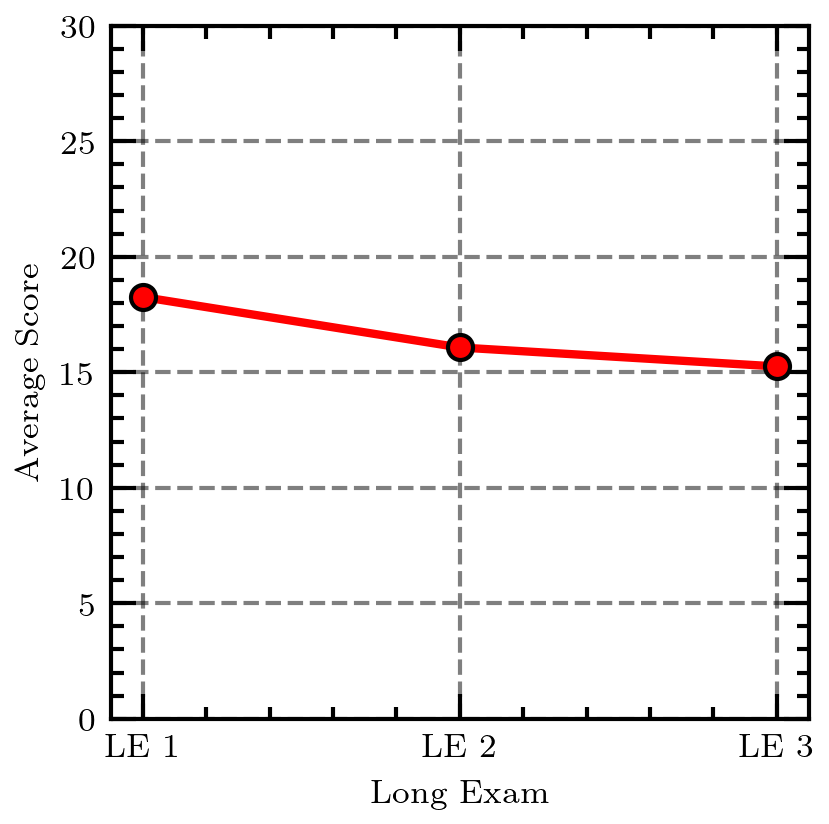

In [15]:
dfA = df.copy()
# Compute the average scores for each LE
average_scores = {
    "LE": ["LE 1", "LE 2", "LE 3"],
    "score": [
        dfA["LE1"].mean(),
        dfA["LE2"].mean(),
        dfA["LE3"].mean()
    ],
    'std': [
        dfA["LE1"].std(),
        dfA["LE2"].std(),
        dfA["LE3"].std()
    ]
}

# Create the DataFrame
df_avg = pd.DataFrame(average_scores)

# Display the result
print(df_avg)
plt.figure(figsize=(3,3), dpi = 300)
plt.plot(df_avg['LE'], df_avg['score'], color ='r', marker = 'o', markeredgecolor='k')
plt.ylim(0,30)
plt.xlabel('Long Exam')
plt.ylabel('Average Score')
plt.show()

  SEMESTER Average Grade        STD
0      1st     66.124381  13.177868
1      2nd     63.814045  13.441738


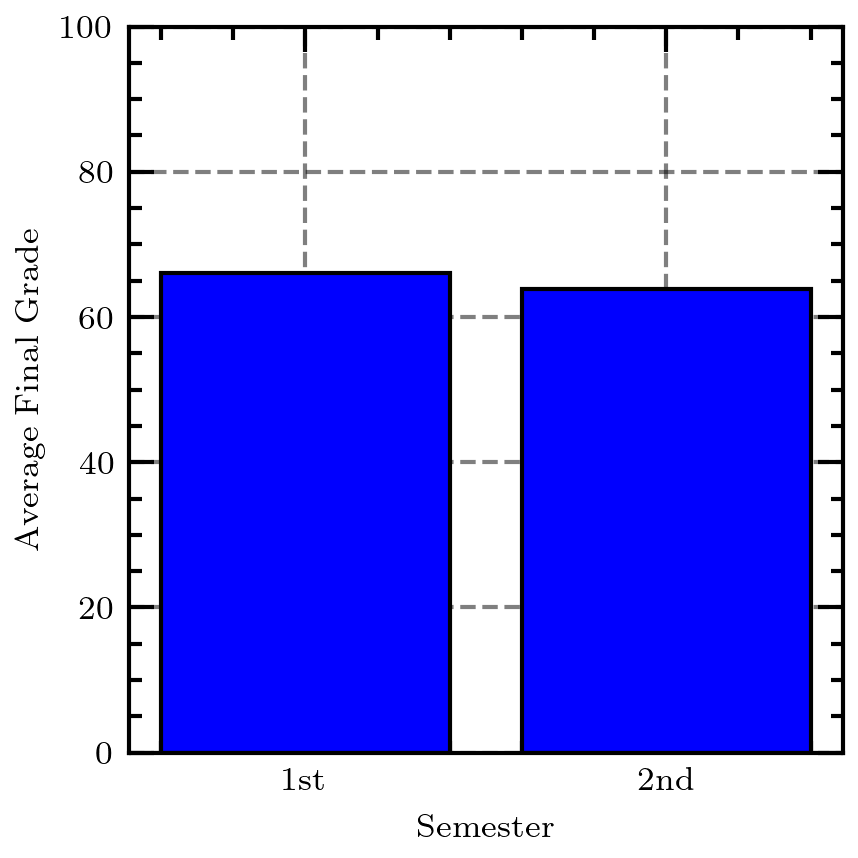

In [16]:
dfI = df
# dfI = dfI.dropna()

# Compute the average grade per course
df_deg = dfI.groupby("SEMESTER")["Final Grade"].agg(['mean', 'std']).reset_index()
df_deg.rename(columns={'mean': 'Average Grade', 'std': 'STD'}, inplace=True)
df
# df_deg = df_deg.sort_values(by="Final Grade", ascending=False)
print(df_deg)

plt.figure(figsize = (3,3), dpi = 300)
plt.bar(df_deg["SEMESTER"],df_deg["Average Grade"], color = 'b', edgecolor = 'k')
plt.ylim(0,100)
plt.xlabel('Semester')
plt.ylabel('Average Final Grade')
plt.tight_layout()
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

  College Final Grade        STD
1     CHE        74.9        NaN
3      CS   69.339071  14.935853
2     COE   65.947357  12.759799
0      CA   56.910419  10.821417


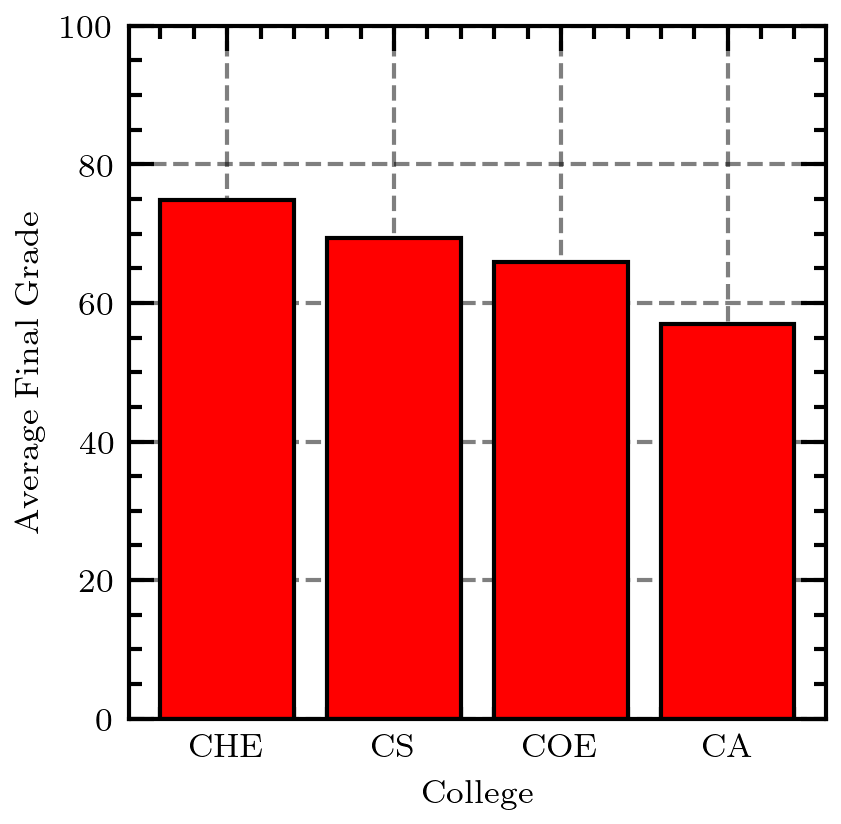

In [17]:
df_col = dfI.copy()

# Dictionary for mapping courses to colleges
course_to_college = {
    'BS CN'  : 'CHE',
    'BS ME'  : 'COE',
    'BS MBB' : 'CS' ,
    'BS CS'  : 'COE',
    'BS Geol': 'CS' ,
    'BS ChE' : 'COE',
    'Bs Math': 'CS' ,
    'BS EE'  : 'COE',
    'BS IE'  : 'COE',
    'BS CoE' : 'COE',
    'BS CE'  : 'COE',
    'BS ECE' : 'COE',
    'BS GE'  : 'COE',
    'BS MetE': 'COE',
    'BS Chem': 'CS' ,
    'BS MatE': 'COE',
    'BS Arch': 'CA' ,
    'BS EM'  : 'COE',
    'BS Bio' : 'CS' ,
    'NON-MAJ': None
}
df_col['College'] = df_col['COURSE'].map(course_to_college)
df_col = df_col.groupby("College")["Final Grade"].agg(['mean', 'std']).reset_index()
df_col.rename(columns={'mean': 'Final Grade', 'std': 'STD'}, inplace=True)
df_col = df_col.sort_values(by="Final Grade", ascending=False)
# df_deg = df_deg.sort_values(by="Final Grade", ascending=False)
print(df_col)
plt.figure(figsize = (3,3), dpi = 300)
plt.bar(df_col["College"],df_col["Final Grade"], color = 'r', edgecolor = 'k')
plt.ylim(0,100)
plt.xlabel('College')
plt.ylabel('Average Final Grade')
fignum +=1
plt.savefig(os.path.join(savepath, f'fig{fignum}.png'))
plt.show()

In [18]:
# Statistics Looooolll
import scipy.stats as stats
import numpy as np

# Given data (excluding Monday and Thursday due to missing values)
means = np.array([66.280471, 65.154289, 65.544573])  # Means for T, W, F
std_devs = np.array([14.064165, 15.168069, 11.822673])  # Standard deviations for T, W, F
n = 425  # Samples per group

# Generate normal distributions based on mean and std deviation
np.random.seed(42)  # For reproducibility
data_T = np.random.normal(means[0], std_devs[0], n)
data_W = np.random.normal(means[1], std_devs[1], n)
data_F = np.random.normal(means[2], std_devs[2], n)

# Perform ANOVA
f_stat, p_value = stats.f_oneway(data_T, data_W, data_F)
f_stat, p_value

(np.float64(3.5481210368561533), np.float64(0.02906383816301006))

In [19]:

# Given data
mean_1st = 66.124
std_1st = 13.178
mean_2nd = 63.814
std_2nd = 13.442
n = 425  # Sample size

# Standard error
se = np.sqrt((std_1st**2 / n) + (std_2nd**2 / n))

# t-statistic
t_stat = (mean_1st - mean_2nd) / se

# Degrees of freedom (Welch's t-test approximation)
df = ((std_1st**2 / n + std_2nd**2 / n) ** 2) / \
     (((std_1st**2 / n) ** 2) / (n - 1) + ((std_2nd**2 / n) ** 2) / (n - 1))

# Two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

t_stat, p_value

(np.float64(2.5298340602599922), np.float64(0.011591768417329007))